In [71]:
import glob
import re
import sqlite3
import time
import traceback
from pathlib import Path

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from PIL import Image

In [72]:
# Paths
mapping_path = r"C:\Users\shubh\Downloads\MSc 3rd Sem\Galaxy_Data\gz2_filename_mapping.csv"
labels_path = r"C:\Users\shubh\Downloads\MSc 3rd Sem\Galaxy_Data\gz2_hart16.csv"

# Load
df_map = pd.read_csv(mapping_path, dtype={"objid": str, "asset_id": str})
df_lbl = pd.read_csv(labels_path, dtype={"dr7objid": str})

print("mapping shape:", df_map.shape)
print("labels  shape:", df_lbl.shape)

print("Mapping file:")
print(df_map.head())

print("\nLabels file:")
print(df_lbl.head())


mapping shape: (355990, 3)
labels  shape: (239695, 231)
Mapping file:
                objid    sample asset_id
0  587722981736120347  original        1
1  587722981736579107  original        2
2  587722981741363294  original        3
3  587722981741363323  original        4
4  587722981741559888  original        5

Labels file:
             dr7objid          ra        dec     rastring    decstring  \
0  587732591714893851  179.042984  60.522518  11:56:10.32  +60:31:21.1   
1  588009368545984617  135.084396  52.494240  09:00:20.26  +52:29:39.3   
2  587732484359913515  183.371979  50.741508  12:13:29.27  +50:44:29.4   
3  587741723357282317  186.251953  28.558598  12:25:00.47  +28:33:31.0   
4  587738410866966577  161.086395  14.084465  10:44:20.73  +14:05:04.1   

     sample gz2_class  total_classifications  total_votes  \
0  original      Sc+t                     45          342   
1  original      Sb+t                     42          332   
2  original        Ei                     

In [73]:
print("\nmapping columns:", df_map.columns.tolist())
print("\nlabels  columns (first 20):", df_lbl.columns.tolist()[:20])

# quick peek
display(df_map.head())
display(df_lbl.head())


mapping columns: ['objid', 'sample', 'asset_id']

labels  columns (first 20): ['dr7objid', 'ra', 'dec', 'rastring', 'decstring', 'sample', 'gz2_class', 'total_classifications', 'total_votes', 't01_smooth_or_features_a01_smooth_count', 't01_smooth_or_features_a01_smooth_weight', 't01_smooth_or_features_a01_smooth_fraction', 't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a01_smooth_flag', 't01_smooth_or_features_a02_features_or_disk_count', 't01_smooth_or_features_a02_features_or_disk_weight', 't01_smooth_or_features_a02_features_or_disk_fraction', 't01_smooth_or_features_a02_features_or_disk_weighted_fraction', 't01_smooth_or_features_a02_features_or_disk_debiased']


,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587732591714893851,179.042984,60.522518,11:56:10.32,+60:31:21.1,original,Sc+t,45,342,0,...,0.450,0.450,0.482646,0,16,16.0,0.400,0.400,0.394506,0
1,588009368545984617,135.084396,52.494240,09:00:20.26,+52:29:39.3,original,Sb+t,42,332,1,...,0.512,0.503,0.504833,0,13,13.0,0.317,0.323,0.322743,0
2,587732484359913515,183.371979,50.741508,12:13:29.27,+50:44:29.4,original,Ei,36,125,28,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
3,587741723357282317,186.251953,28.558598,12:25:00.47,+28:33:31.0,original,Sc+t,28,218,1,...,0.240,0.240,0.241322,0,6,6.0,0.240,0.240,0.239765,0
4,587738410866966577,161.086395,14.084465,10:44:20.73,+14:05:04.1,original,Er,43,151,33,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0


In [74]:
images_dir   = r"C:\Users\shubh\Downloads\MSc 3rd Sem\Galaxy_Data\images"

In [75]:
out_merged_csv = r"C:\Users\shubh\Downloads\MSc 3rd Sem\Galaxy_Morphology_Final\merged_labels_assets.csv"

In [76]:
df = pd.merge(df_map, df_lbl, left_on="objid", right_on="dr7objid", how="inner", suffixes=("_map", "_lbl"))

print("merged shape:", df.shape)
display(df.head())
display(df[["asset_id", "objid", "dr7objid", "gz2_class"]].head())

merged shape: (239695, 234)


,objid,sample_map,asset_id,dr7objid,ra,dec,rastring,decstring,sample_lbl,gz2_class,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587722981741363294,original,3,587722981741363294,182.925262,-1.092357,12:11:42.06,-01:05:32.5,original,Sb,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
1,587722981741363323,original,4,587722981741363323,182.970108,-1.219537,12:11:52.83,-01:13:10.3,original,Sc?l,...,0.0,0.0,0.0,0,1,1.0,1.0,1.0,1.0,1
2,587722981741559888,original,5,587722981741559888,183.438095,-1.238414,12:13:45.14,-01:14:18.3,original,Er,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,587722981741625481,original,6,587722981741625481,183.473999,-1.231429,12:13:53.76,-01:13:53.1,original,Sc1t,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,587722981741625484,original,7,587722981741625484,183.477783,-1.084604,12:13:54.67,-01:05:04.6,original,Sb,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


,asset_id,objid,dr7objid,gz2_class
0,3,587722981741363294,587722981741363294,Sb
1,4,587722981741363323,587722981741363323,Sc?l
2,5,587722981741559888,587722981741559888,Er
3,6,587722981741625481,587722981741625481,Sc1t
4,7,587722981741625484,587722981741625484,Sb


In [77]:
df["filename"] = df["asset_id"].astype(str) + ".jpg"
df["file_path"] = df["filename"].apply(lambda f: os.path.join(images_dir, f))
df["file_exists"] = df["file_path"].apply(os.path.exists)

print("Files matched:", df["file_exists"].sum(), " / ", len(df))
print("Missing files:", len(df) - df["file_exists"].sum())

# show a few missing examples (if any)
display(df.loc[~df["file_exists"], ["asset_id", "filename", "objid"]].head())

Files matched: 239573  /  239695
Missing files: 122


,asset_id,filename,objid
341,374,374.jpg,587722982290620479
5212,7349,7349.jpg,587725471205490852
5213,7350,7350.jpg,587725471205556327
5214,7351,7351.jpg,587725471205556424
8380,10959,10959.jpg,587725577498591551


In [78]:
df = df[df["file_exists"]].copy()
print("After filtering:", len(df))
df.shape

After filtering: 239573


(239573, 237)

In [79]:
df.to_csv(out_merged_csv, index=False)

Now, we need to finalize the target columns, extract the 37 debiased probability columns (make sure they sum to 1 within each task, but not necessarily across all 37 since some tasks are conditional) and save them in a NumPy array (shape: [num_samples, 37]).

In [80]:
target_cols = [col for col in df.columns if col.endswith("_debiased")]
print(len(target_cols))   
print(target_cols[:10])   


37
['t01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a02_features_or_disk_debiased', 't01_smooth_or_features_a03_star_or_artifact_debiased', 't02_edgeon_a04_yes_debiased', 't02_edgeon_a05_no_debiased', 't03_bar_a06_bar_debiased', 't03_bar_a07_no_bar_debiased', 't04_spiral_a08_spiral_debiased', 't04_spiral_a09_no_spiral_debiased', 't05_bulge_prominence_a10_no_bulge_debiased']


In [81]:
df[target_cols] = df[target_cols].fillna(0.0)

In [82]:
Y = df[target_cols].to_numpy()   
print(Y.shape)  


(239573, 37)


In [83]:
# List of tasks and their debiased columns
tasks = {
    "t01_smooth_or_features": [
        "t01_smooth_or_features_a01_smooth_debiased",
        "t01_smooth_or_features_a02_features_or_disk_debiased",
        "t01_smooth_or_features_a03_star_or_artifact_debiased"
    ],
    "t02_edgeon": [
        "t02_edgeon_a04_yes_debiased",
        "t02_edgeon_a05_no_debiased"
    ],
    "t03_bar": [
        "t03_bar_a06_bar_debiased",
        "t03_bar_a07_no_bar_debiased"
    ],
    "t04_spiral": [
        "t04_spiral_a08_spiral_debiased",
        "t04_spiral_a09_no_spiral_debiased"
    ],
    "t05_bulge_prominence": [
        "t05_bulge_prominence_a10_no_bulge_debiased",
        "t05_bulge_prominence_a11_just_noticeable_debiased",
        "t05_bulge_prominence_a12_obvious_debiased",
        "t05_bulge_prominence_a13_dominant_debiased"
    ],
    "t06_odd": [
        "t06_odd_a14_yes_debiased",
        "t06_odd_a15_no_debiased"
    ],
    "t07_rounded": [
        "t07_rounded_a16_completely_round_debiased",
        "t07_rounded_a17_in_between_debiased",
        "t07_rounded_a18_cigar_shaped_debiased"
    ],
    "t08_odd_feature": [
        "t08_odd_feature_a19_ring_debiased",
        "t08_odd_feature_a20_lens_or_arc_debiased",
        "t08_odd_feature_a21_disturbed_debiased",
        "t08_odd_feature_a22_irregular_debiased",
        "t08_odd_feature_a23_other_debiased",
        "t08_odd_feature_a24_merger_debiased"
    ],
    "t09_bulge_shape": [
        "t09_bulge_shape_a25_round_debiased",
        "t09_bulge_shape_a26_boxy_debiased",
        "t09_bulge_shape_a27_no_bulge_debiased"
    ],
    "t10_spiral_winding": [
        "t10_spiral_winding_a28_tight_debiased",
        "t10_spiral_winding_a29_medium_debiased",
        "t10_spiral_winding_a30_loose_debiased"
    ],
    "t11_spiral_arm_count": [
        "t11_spiral_arm_count_a31_1_debiased",
        "t11_spiral_arm_count_a32_2_debiased",
        "t11_spiral_arm_count_a33_3_debiased",
        "t11_spiral_arm_count_a34_4_debiased",
        "t11_spiral_arm_count_a36_more_than_4_debiased",
        "t11_spiral_arm_count_a37_cant_tell_debiased"
    ]
}


In [84]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


In [85]:
# Step 0: clean Y (replace NaNs with 0)
Y_clean = np.nan_to_num(Y, nan=0.0)

# Step 1: create stratified splitter
msss_outer = MultilabelStratifiedShuffleSplit(
    n_splits=1, 
    test_size=15000, 
    random_state=42
)

# Step 2: run stratified split
train_full_idx, subset_idx = next(msss_outer.split(np.zeros(len(Y_clean)), Y_clean))

print(len(subset_idx))  # should be 15000
print(len(train_full_idx))  # the rest


15089
224484


In [86]:
# Step 3: Stratified split of the 15,089 subset into 10k / 5k
subset_Y = Y_clean[subset_idx]

msss_inner = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=5000,   # we want 5k validation
    random_state=42
)

train_idx, val_idx = next(msss_inner.split(np.zeros(len(subset_Y)), subset_Y))

# map indices back to original dataset
subset_train_idx = subset_idx[train_idx]
subset_val_idx   = subset_idx[val_idx]

print(len(subset_train_idx))  # should be ~10089
print(len(subset_val_idx))    # should be 5000


10076
5013


In [87]:
print(subset_idx.shape)
print(subset_Y.shape)

(15089,)
(15089, 37)


In [88]:
# Parameters
img_size = (128, 128)
# subset_train_idx and subset_val_idx were obtained from your stratified splitting
all_required_idx = np.concatenate([subset_train_idx, subset_val_idx])

# List all image filenames (sorted so indices match)
image_files = sorted([os.path.join(images_dir, f) 
                      for f in os.listdir(images_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Prepare arrays
X_train = []
X_val = []

for i, idx in enumerate(all_required_idx):
    path = image_files[idx]  # index in the full dataset
    img = Image.open(path).convert('L')  # grayscale
    img = img.resize(img_size)
    img_array = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]

    if idx in subset_train_idx:
        X_train.append(img_array)
    else:
        X_val.append(img_array)

# Convert lists to numpy arrays with shape (num_samples, 128, 128, 1)
X_train = np.expand_dims(np.array(X_train), -1)
X_val = np.expand_dims(np.array(X_val), -1)

In [89]:
# Save arrays
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("Y_train.npy", Y_clean[subset_train_idx])
np.save("Y_val.npy", Y_clean[subset_val_idx])

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("Y_train:", Y_clean[subset_train_idx].shape)
print("Y_val:", Y_clean[subset_val_idx].shape)

Shapes:
X_train: (10076, 128, 128, 1)
X_val: (5013, 128, 128, 1)
Y_train: (10076, 37)
Y_val: (5013, 37)


In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class GalaxyDataset(Dataset):
    def __init__(self, dataframe, img_dir, target_cols, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.target_cols = target_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")  # keep RGB for augmentation
        label = row[self.target_cols].values.astype("float32")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Use your transform pipeline
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Build datasets from merged dataframe (df) and target_cols
train_df = df.iloc[subset_train_idx]
val_df   = df.iloc[subset_val_idx]

train_dataset = GalaxyDataset(train_df, images_dir, target_cols, transform=transform)
val_dataset   = GalaxyDataset(val_df, images_dir, target_cols, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


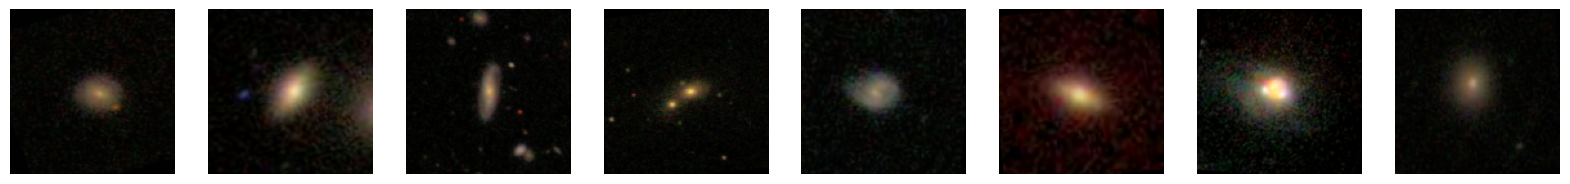

In [91]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 8, figsize=(20, 4))
for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.show()


In [92]:
import torch.nn as nn
import torch.nn.functional as F

class StableCNN(nn.Module): # Renamed for clarity
    def __init__(self):
        super(StableCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Add BatchNorm for 32 channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Add BatchNorm for 64 channels
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Add BatchNorm for 128 channels
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        # Fully Connected Head
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 37)

    def forward(self, x):
        # The forward pass now includes passing through the BatchNorm layers
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = StableCNN()

In [93]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

# 1. Define BOTH training and validation transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])





In [94]:
# After creating your train_loader, before the training loop
print("--- Checking a batch of data ---")
inputs, labels = next(iter(train_loader))
print(f"Inputs min: {inputs.min()}, max: {inputs.max()}")
print(f"Labels min: {labels.min()}, max: {labels.max()}")

# Check if any values are nan
print(f"Any nans in inputs? {torch.isnan(inputs).any()}")
print(f"Any nans in labels? {torch.isnan(labels).any()}")
print("---------------------------------")

--- Checking a batch of data ---
Inputs min: 0.0, max: 1.0
Labels min: 0.0, max: 1.0
Any nans in inputs? False
Any nans in labels? False
---------------------------------


In [96]:
import torch
import torch.optim as optim
from tqdm import tqdm # A library for nice progress bars!

# --- 1. SETUP ---
# (Assuming model, train_loader, and val_loader are already defined)

model = StableCNN()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set the device (use GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the chosen device
model.to(device)

# --- 2. TRAINING ---
num_epochs = 10 # Start with 10 and see how it goes
best_val_loss = float('inf') # Initialize with a very high value

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    running_train_loss = 0.0
    
    # Use tqdm for a progress bar
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    
    for batch_idx, (inputs, labels) in enumerate(train_progress_bar):
        # Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        

        if torch.isnan(loss):
            print(f"\n!!! NaN loss detected at batch index: {batch_idx} !!!")
            
            # Save the problematic batch for inspection
            torch.save(inputs, 'bad_batch_inputs.pt')
            torch.save(labels, 'bad_batch_labels.pt')
            
            print("Problematic batch saved to 'bad_batch_inputs.pt' and 'bad_batch_labels.pt'")
            print("Stopping training.")
            # You must exit or break here, as continuing is pointless
            import sys
            sys.exit() # or just `break` if you want the epoch to finish
            
        # Backward pass and optimize
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        # Update running loss and progress bar
        running_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    
    # Disable gradient calculations for validation
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            val_progress_bar.set_postfix(loss=loss.item())

    # --- 3. REPORTING & SAVING ---
    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    
    # Calculate RMSE for the validation set
    val_rmse = torch.sqrt(torch.tensor(avg_val_loss))
    
    print(f"Epoch {epoch+1}/{num_epochs} -> "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val RMSE: {val_rmse:.4f}")
    
    # Save the model if it has the best validation loss so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_galaxy_model.pth')
        print(f"🎉 New best model saved with Val Loss: {best_val_loss:.4f}")

print("\n--- Training Finished ---")

Using device: cpu


Epoch 1/10 [Validation]: 100%|██████████| 157/157 [01:32<00:00,  1.70it/s, loss=0.0672]


Epoch 1/10 -> Train Loss: 0.0768 | Val Loss: 0.0710 | Val RMSE: 0.2665
🎉 New best model saved with Val Loss: 0.0710


Epoch 2/10 [Validation]: 100%|██████████| 157/157 [01:21<00:00,  1.91it/s, loss=0.0649]


Epoch 2/10 -> Train Loss: 0.0694 | Val Loss: 0.0696 | Val RMSE: 0.2638
🎉 New best model saved with Val Loss: 0.0696


Epoch 3/10 [Validation]: 100%|██████████| 157/157 [01:22<00:00,  1.89it/s, loss=0.062] 


Epoch 3/10 -> Train Loss: 0.0671 | Val Loss: 0.0661 | Val RMSE: 0.2572
🎉 New best model saved with Val Loss: 0.0661


Epoch 4/10 [Validation]: 100%|██████████| 157/157 [01:23<00:00,  1.87it/s, loss=0.0616]


Epoch 4/10 -> Train Loss: 0.0662 | Val Loss: 0.0665 | Val RMSE: 0.2579


Epoch 5/10 [Validation]: 100%|██████████| 157/157 [01:22<00:00,  1.90it/s, loss=0.0604]


Epoch 5/10 -> Train Loss: 0.0651 | Val Loss: 0.0653 | Val RMSE: 0.2556
🎉 New best model saved with Val Loss: 0.0653


Epoch 6/10 [Validation]: 100%|██████████| 157/157 [05:57<00:00,  2.28s/it, loss=0.0609]


Epoch 6/10 -> Train Loss: 0.0639 | Val Loss: 0.0642 | Val RMSE: 0.2534
🎉 New best model saved with Val Loss: 0.0642


Epoch 7/10 [Validation]: 100%|██████████| 157/157 [01:43<00:00,  1.51it/s, loss=0.0613]


Epoch 7/10 -> Train Loss: 0.0631 | Val Loss: 0.0646 | Val RMSE: 0.2541


Epoch 8/10 [Validation]: 100%|██████████| 157/157 [01:28<00:00,  1.78it/s, loss=0.063] 


Epoch 8/10 -> Train Loss: 0.0623 | Val Loss: 0.0656 | Val RMSE: 0.2561


Epoch 9/10 [Validation]: 100%|██████████| 157/157 [01:56<00:00,  1.35it/s, loss=0.0603]


Epoch 9/10 -> Train Loss: 0.0618 | Val Loss: 0.0638 | Val RMSE: 0.2526
🎉 New best model saved with Val Loss: 0.0638


Epoch 10/10 [Validation]: 100%|██████████| 157/157 [02:17<00:00,  1.14it/s, loss=0.0594]


Epoch 10/10 -> Train Loss: 0.0612 | Val Loss: 0.0618 | Val RMSE: 0.2485
🎉 New best model saved with Val Loss: 0.0618

--- Training Finished ---
